In [1]:
!python --version

Python 3.6.12 :: Anaconda custom (64-bit)


In [2]:
#!pip install -q -U pip
#!pip install -q numpy
#!pip install -q pandas
#!pip install -q ckiptagger
#!pip install -q tqdm
#!pip install -q tensorflow==1.14.0
#!pip install -q ipywidgets
#!pip install -q matplotlib

In [3]:
import pandas as pd
import numpy as np

from ckiptagger import WS, POS
from tqdm.notebook import tqdm

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [4]:
df_train = pd.read_csv('news_clustering_train.tsv', sep='\t')
df_test = pd.read_csv('news_clustering_test.tsv', sep='\t')

In [5]:
train_titles = {row['index']: row['title'] for _, row in df_train.iterrows()}
train_classes = {row['index']: row['class'] for _, row in df_train.iterrows()}

test_titles = {row['index']: row['title'] for _, row in df_test.iterrows()}
test_classes = {row['index']: row['class'] for _, row in df_test.iterrows()}

In [6]:
all_news_class = ['體育', '財經', '科技', '旅遊', '農業', '遊戲']

# 斷詞 + POS

In [7]:
ws = WS(("C:/Users/angus.tu/Downloads/NLP_tmp/D07data"))
pos = POS(("C:/Users/angus.tu/Downloads/NLP_tmp/D07data"))

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\layers\legacy_rnn\rnn_cell_impl.py:903: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.LSTMCell` is deprecated and will be "
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [8]:
train_title_cuts = {}
for index, title in tqdm(train_titles.items()):
    word_s = ws([title])
    word_p = pos(word_s)
    train_title_cuts[index] = list(zip(word_s[0], word_p[0]))

In [12]:
train_title_cuts[100]

[('山東', 'Nc'),
 ('魯能', 'Nb'),
 ('有沒有', 'D'),
 ('可能', 'D'),
 ('拿到', 'VC'),
 ('今年', 'Nd'),
 ('的', 'DE'),
 ('中', 'A'),
 ('超', 'A'),
 ('冠軍', 'Na'),
 ('？', 'QUESTIONCATEGORY')]

In [9]:
test_title_cuts = {}
for index, title in tqdm(test_titles.items()):
    word_s = ws([title])
    word_p = pos(word_s)
    test_title_cuts[index] = list(zip(word_s[0], word_p[0]))

In [11]:
test_title_cuts

{1800: [('如果', 'Cbb'),
  ('騎士', 'Na'),
  ('火箭', 'Na'),
  ('進入', 'VCL'),
  ('總決賽', 'Na'),
  ('，', 'COMMACATEGORY'),
  ('誰', 'Nh'),
  ('的', 'DE'),
  ('勝算', 'Na'),
  ('大', 'VH'),
  ('？', 'QUESTIONCATEGORY')],
 1801: [('從', 'P'),
  ('個人', 'Nh'),
  ('競技', 'Nv'),
  ('狀態', 'Na'),
  ('來', 'D'),
  ('看', 'VE'),
  ('，', 'COMMACATEGORY'),
  ('三', 'Neu'),
  ('個', 'Nf'),
  ('階段', 'Na'),
  ('的', 'DE'),
  ('詹姆斯', 'Nb'),
  ('，', 'COMMACATEGORY'),
  ('哪', 'Nep'),
  ('個', 'Nf'),
  ('最', 'Dfa'),
  ('強', 'VH'),
  ('？', 'QUESTIONCATEGORY')],
 1802: [('騎士', 'Na'),
  ('總冠軍', 'Na'),
  ('！', 'EXCLAMATIONCATEGORY'),
  ('地球人', 'Na'),
  ('誰', 'Nh'),
  ('能', 'D'),
  ('阻擋', 'VC'),
  ('詹姆斯', 'Nb'),
  ('？', 'QUESTIONCATEGORY'),
  ('史', 'Na'),
  ('上', 'Ncd'),
  ('最佳', 'A'),
  ('就', 'D'),
  ('是', 'SHI'),
  ('他', 'Nh'),
  ('！', 'EXCLAMATIONCATEGORY'),
  ('打服', 'VC'),
  ('所有人', 'Na')],
 1803: [('詹姆斯', 'Nb'),
  ('絕殺', 'VH'),
  ('，', 'COMMACATEGORY'),
  ('騎士', 'Na'),
  ('3', 'Neu'),
  ('比', 'Caa'),
  ('0', 'Neu'),
  ('，', '

# Bag of Words (BOW)

In [13]:
word2index = {}
index2word = {}
n = 0
for index in train_title_cuts:
    for word, flag in train_title_cuts[index]:
        if word in word2index:
            continue
        word2index[word] = n 
        index2word[n] = word
        n += 1

In [14]:
def get_bow_vector_with_selection(pairs, word2index):
    excluded_flags = [
        'Nh', 'Nep', 'Nes', 'DE', 'T', 'P', 'V_2', 'SHI',
        'Dfa', 'Dfb', 'Da', 'Di', 'Dk',
        'Caa', 'Cab', 'Cba', 'Cbb',
        'COLONCATEGORY', 'COMMACATEGORY', 'DASHCATEGORY', 'DOTCATEGORY', 'ETCCATEGORY', 'EXCLAMATIONCATEGORY',
        'PARENTHESISCATEGORY', 'PAUSECATEGORY', 'PERIODCATEGORY', 'QUESTIONCATEGORY', 'SEMICOLONCATEGORY',
        'SPCHANGECATEGORY', 'WHITESPACE'
    ]
    vector = np.zeros(len(word2index))
    for word, flag in pairs:
        if word in word2index and flag not in excluded_flags:
            vector[word2index[word]] += 1
    return vector

In [15]:
train_bow_vectors = {
    index: get_bow_vector_with_selection(pairs, word2index)
    for index, pairs in train_title_cuts.items()
}

test_bow_vectors = {
    index: get_bow_vector_with_selection(pairs, word2index)
    for index, pairs in test_title_cuts.items()
}

# TFIDF

In [16]:
from sklearn.feature_extraction.text import TfidfTransformer

In [17]:
train_index_array, train_vector_array = list(zip(*train_bow_vectors.items()))

# 使用`TfidfTransformer`來將`train_vector_array`轉換成`train_tfidf_vector_array`
# YOUR CODE HERE
transformer = TfidfTransformer(smooth_idf=True)
train_tfidf_vector_array = transformer.fit_transform(train_vector_array)
# END YOUR CODE

In [18]:
train_tfidf_vector_array

<1800x6690 sparse matrix of type '<class 'numpy.float64'>'
	with 17126 stored elements in Compressed Sparse Row format>

In [19]:
type(train_tfidf_vector_array)

scipy.sparse.csr.csr_matrix

In [20]:
train_tfidf_vectors = {}
for i, index in enumerate(train_index_array):
    vector = train_tfidf_vector_array.getrow(i).toarray()[0]
    train_tfidf_vectors[index] = vector

In [21]:
train_tfidf_vectors[120]

array([0., 0., 0., ..., 0., 0., 0.])

In [22]:
test_index_array, test_vector_array = list(zip(*test_bow_vectors.items()))

# 使用同一個`TfidfTransformer`來轉換testing dataset
# YOUR CODE HERE
transformer = TfidfTransformer(smooth_idf=True)
test_tfidf_vector_array = transformer.fit_transform(test_vector_array)
# END YOUR CODE

In [23]:
test_tfidf_vector_array

<600x6690 sparse matrix of type '<class 'numpy.float64'>'
	with 4262 stored elements in Compressed Sparse Row format>

In [24]:
test_tfidf_vectors = {}
for i, index in enumerate(test_index_array):
    vector = test_tfidf_vector_array.getrow(i).toarray()
    test_tfidf_vectors[index] = vector

# TFIDF + Group mean vector: 測試

In [25]:
group_vectors = {news_class: [] for news_class in all_news_class}
for index, vector in sorted(train_tfidf_vectors.items()):
    news_class = train_classes[index]
    group_vectors[news_class].append(vector)

group_mean_vector = {}
for news_class, vectors in group_vectors.items():
    group_mean_vector[news_class] = np.mean(vectors, axis=0)
group_mean_vector

{'體育': array([0.01151249, 0.00394476, 0.00120532, ..., 0.        , 0.        ,
        0.        ]),
 '財經': array([0., 0., 0., ..., 0., 0., 0.]),
 '科技': array([0., 0., 0., ..., 0., 0., 0.]),
 '旅遊': array([0., 0., 0., ..., 0., 0., 0.]),
 '農業': array([0., 0., 0., ..., 0., 0., 0.]),
 '遊戲': array([0.        , 0.        , 0.        , ..., 0.00171764, 0.00152024,
        0.00152024])}

In [26]:
def cosine_similarity(bow1, bow2):
    len_bow1 = np.sqrt(np.sum(np.square(bow1)))
    len_bow2 = np.sqrt(np.sum(np.square(bow2)))
    return np.sum(bow1 * bow2) / (len_bow1 * len_bow2)

In [27]:
classification = {news_class: [] for news_class in all_news_class}
for index, vector in sorted(test_tfidf_vectors.items()):
    if np.sum(np.square(vector)) == 0:
        continue

    max_val = -2.0
    max_class = None
    for news_class, ref_vector in group_mean_vector.items():
        val = cosine_similarity(ref_vector, vector)
        if val > max_val:
            max_class = news_class
            max_val = val

    classification[max_class].append(index)

In [28]:
from collections import Counter

for group, ids in classification.items():
    counter = Counter([test_classes[id] for id in ids])
    print('predict', group, ': ', counter)

predict 體育 :  Counter({'體育': 83, '遊戲': 7, '財經': 6, '旅遊': 6, '科技': 3, '農業': 3})
predict 財經 :  Counter({'財經': 76, '科技': 14, '旅遊': 6, '農業': 6, '體育': 4, '遊戲': 2})
predict 科技 :  Counter({'科技': 66, '財經': 11, '農業': 6, '體育': 3, '遊戲': 3, '旅遊': 1})
predict 旅遊 :  Counter({'旅遊': 78, '農業': 10, '科技': 5, '財經': 3, '遊戲': 1})
predict 農業 :  Counter({'農業': 74, '旅遊': 7, '科技': 6, '體育': 4, '財經': 2, '遊戲': 1})
predict 遊戲 :  Counter({'遊戲': 86, '科技': 5, '體育': 4, '財經': 2})


# Visualization

In [40]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='full')

anchor_classes, anchor_vectors = list(zip(*group_mean_vector.items()))
# 為了看清楚Group Mean Vector怎麼幫助我們做分類問題，我們針對Group Mean Vector (anchor) 來進行PCA降維
# YOUR CODE HERE
pca.fit(anchor_vectors)
reduced_anchor_vectors = pca.transform(anchor_vectors)

reduced_test_tfidf_vector_array = pca.transform(test_tfidf_vector_array.toarray())
# END YOUR CODE

In [43]:
reduced_anchor_vectors

array([[-0.02149987, -0.01955512],
       [-0.01250651,  0.03454422],
       [ 0.01532441,  0.06634181],
       [-0.04399492, -0.05766664],
       [-0.02597584,  0.01259888],
       [ 0.08865273, -0.03626315]])

In [41]:
reduced_test_tfidf_vector_array

array([[-0.02447703, -0.0318951 ],
       [ 0.03662089, -0.08792716],
       [-0.02693275, -0.04781636],
       ...,
       [ 0.04506187, -0.05394296],
       [ 0.10487201, -0.04521801],
       [ 0.03227716, -0.03324108]])

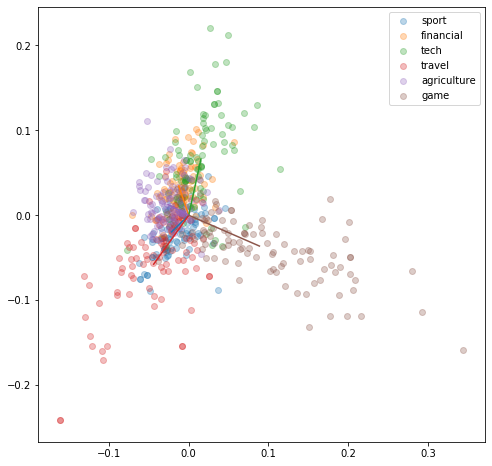

In [42]:
import matplotlib
import matplotlib.pyplot as plt

test_class_array = np.vectorize(test_classes.get)(test_index_array)

label_mapping = {
    '體育': 'sport',
    '財經': 'financial',
    '科技': 'tech',
    '旅遊': 'travel',
    '農業': 'agriculture',
    '遊戲': 'game'
}

plt.figure(figsize=(8, 8))
for real_class in all_news_class:
    plt.scatter(reduced_test_tfidf_vector_array[test_class_array == real_class, 0],
                reduced_test_tfidf_vector_array[test_class_array == real_class, 1],
                label=label_mapping[real_class],
                alpha=0.3)
    i = anchor_classes.index(real_class)
    plt.plot([0, reduced_anchor_vectors[i, 0]], [0, reduced_anchor_vectors[i, 1]])
plt.legend(loc="best", shadow=False, scatterpoints=1)

plt.show()